## SOT JAX using L2 

This code retrieves a surface map from reflection integrated light curve of an Earth analog.

See 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  

You need healpy, jax, sot package https://github.com/HajimeKawahara/sot.  

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
from jax import random
from sot.core import jaxweight as jw

In [5]:
#set geometry
inc=0.0
Thetaeq=np.pi
zeta=np.pi/3.0
                                                                                                
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
#Porb=365.242190402                                            
Porb=40.0
worb=2*np.pi/Porb                                                                                                                
N=1024
obst=jnp.linspace(0.0,Porb,N)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


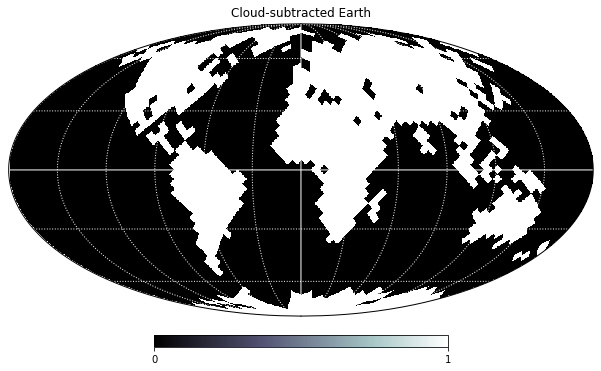

In [6]:
# test map
nside=16
mmap=(hp.read_map("../data/mockalbedo16.fits"))
mask=(mmap>0.0)
mmap[mask]=1.0
mmap=jnp.asarray(mmap)
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [15]:
Thetav=worb*obst
Phiv=jnp.mod(wspin*obst,2*np.pi)

WI,WV=jw.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)

In [16]:
W=jnp.array(WV*WI)
lc=jnp.dot(W,mmap)

key = random.PRNGKey(0)
sigma=jnp.mean(lc)*0.0
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

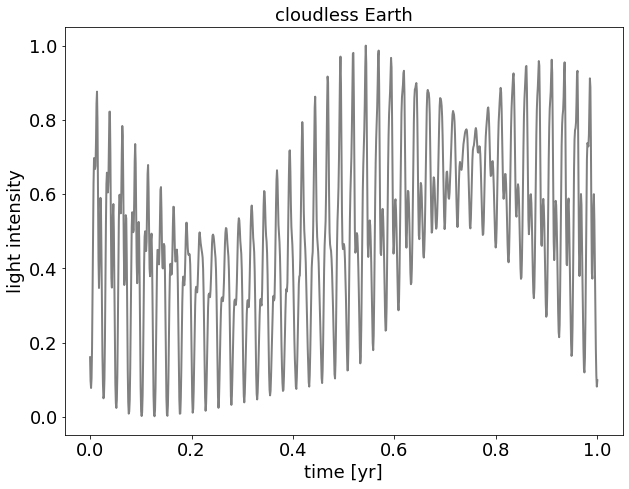

In [17]:
fig= plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [65]:
# loss or objective function
def objective(m):
    lam=2.0
    f=jnp.sum((lc - jnp.dot(W,m))**2) + lam*jnp.sum(m*m)
    return f

In [81]:
# ADAM 
#see https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html 

m0 = jnp.array(np.random.normal(0.0,1.0,np.shape(mmap)))
opt_init, opt_update, get_params = optimizers.adam(1e0)
opt_state = opt_init(m0)

@jit
def step(t, opt_state):
    value, grads = value_and_grad(objective)(get_params(opt_state))
    opt_state = opt_update(t, grads, opt_state)
    return value, opt_state

for t in range(10000):
    value, opt_state = step(t, opt_state)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


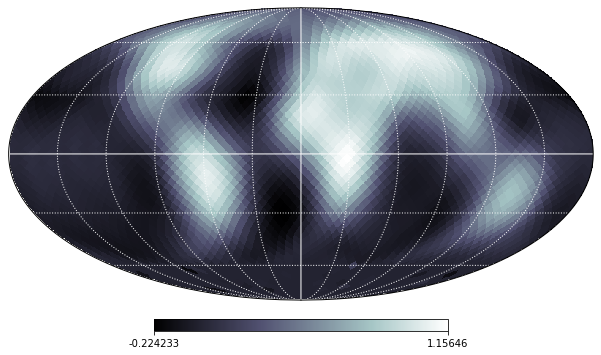

In [82]:
m = get_params(opt_state)
mnp=np.array(m)
hp.mollview(mnp, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");

In [41]:
#steepst gradient descent (slow)
m = jnp.array(np.random.normal(0.0,1.0,np.shape(mmap)))
tmp_val = 1e5
while True:
    val, grad_val = value_and_grad(objective)(m)
    m = m - 1e-5*grad_val
    #print(tmp_val,jnp.abs(val - tmp_val).sum())
    if jnp.abs(val - tmp_val).sum() < 0.5:
        break
    tmp_val = val

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


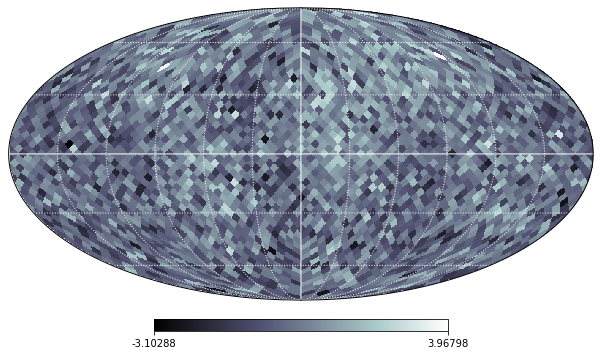

In [42]:
mnp=np.array(m)
hp.mollview(mnp, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");